In [342]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 

import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error #=mean error (Simon 2012)
from sklearn.metrics import r2_score

from scipy.spatial import distance
from sklearn.metrics.pairwise import nan_euclidean_distances

from matplotlib.lines import Line2D
from matplotlib import rcParams, cycler
from sklearn.preprocessing import PowerTransformer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [343]:
import warnings
warnings.filterwarnings("ignore")

## Functions

In [344]:
def initialize(threshold, start_time):
#     PM25 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/PM25")
    PM25 = pd.read_pickle("~/Documents/saved_data_from_notebooks/PM25") #Lab's computer

    times = pd.date_range(start=start_time, end='2018-12-31 23:00:00', freq='30Min') #one less because the last is always nan

    start_idx = PM25.shape[0]-times.shape[0]

    # remove the last index as it is always nan
    PM25 = PM25[:-1]
    times = times[:-1]

    # reduced PM25 
    r_PM25 = PM25[start_idx:] 
    idx = r_PM25.notnull().sum(axis = 0)/r_PM25.shape[0]>threshold
    r_PM25 = r_PM25.loc[:, idx]

    r_PM25.reset_index(inplace=True)
    r_PM25.drop(labels = 'index',axis=1, inplace=True)
    
    return times, r_PM25

In [353]:
# in case I want to change my method to choosing in advance X chunks. I think it might
# induce a bias and it is better to bootstrap. 

PM25 =  r_PM25.copy()
interval_length = 1440
s = 0
exclude = [1]

valid_locations = (PM25.iloc[:,s].isnull().rolling(interval_length,min_periods=0).sum()<(interval_length/100))
PM25.index[valid_locations]
# valid_locations.sum()

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            101872, 101873, 101874, 101875, 101876, 101877, 101878, 101879,
            101880, 101881],
           dtype='int64', length=22092)

In [395]:
ar = [1,2,3,4,5,np.nan,np.nan,np.nan,4,np.nan,np.nan,np.nan,np.nan,3,46,2,7,np.nan,3,5,np.nan,1,2,3,4,5,np.nan,np.nan,np.nan,4,np.nan,np.nan,np.nan,np.nan,3,46,2,7,np.nan,3,5,np.nan]
df = pd.DataFrame(ar)

In [396]:
df

,0
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0
5,NaN
6,NaN
7,NaN
8,4.0
9,NaN


In [510]:
# total_excude = []
int_l = 2
how_many = 3
pot_idx = np.argwhere((df.iloc[:,0].notnull().rolling(int_l,min_periods=0).sum()>(int_l-int_l/100)).values).ravel()
# df.iloc[:,0].notnull().rolling(int_l,min_periods=0).sum()>(int_l-int_l/100)

chosen_idx = pot_idx[(~np.isnan(df.iloc[pot_idx-int_l,0].values)) & (~np.isnan(df.iloc[pot_idx+1,0].values)) & (pot_idx>=int_l)]


# np.random.choice([i for i in chosen_idx if i not in exclude])
chosen = np.random.choice(chosen_idx,how_many,replace=False)+1

pot_idx
chosen_idx
# total_excude = (list(chosen-int_l),list(chosen))
# total_excude

array([ 1,  2,  3,  4, 14, 15, 16, 19, 22, 23, 24, 25, 35, 36, 37, 40])

array([ 2,  3, 15, 23, 24, 36])

([35, 1, 14], [37, 3, 16])

In [534]:
total_excude

([35, 1, 14], [37, 3, 16])

In [516]:
A,B = total_excude

In [517]:
A
B

[35, 1, 14]

[37, 3, 16]

In [586]:
for a,b in zip(A,B):
    range(a,b)   
    chosen_idx=[x for x in chosen_idx if x not in range(a,b)]

range(35, 37)

range(1, 3)

range(14, 16)

In [587]:
chosen_idx

[3, 23, 24]

In [521]:
[x for x in chosen_idx if all(x not in range(a,b) for a, b in zip(A, B))]

[3, 23, 24]

In [ ]:
chosen_idx

In [4]:
# # create a np_array np_y_missing, fill the np_y_missing with values where the validation
# # indexes are chosen. 

# def get_validation_index(PM25, interval_length, s, exclude):    
    
#     idx_start = np.random.choice([i for i in range(0,len(PM25.iloc[:,s])) if i not in exclude])
#     condition = PM25.iloc[idx_start:idx_start+interval_length,s].isnull().rolling(interval_length,min_periods=0).sum().max()
    
#     # I allow some nan values (1%) to be inside in validation interval. 
#     while ((condition>interval_length/100) or (np.isnan(PM25.iloc[idx_start-1,s])) or (np.isnan(PM25.iloc[idx_start+interval_length+1,s])) or ((idx_start+interval_length+1)>len(PM25.iloc[:,s]))):
#         idx_start = np.random.choice([i for i in range(0,len(PM25.iloc[:,s])) if i not in exclude])
#         condition = PM25.iloc[idx_start:idx_start+interval_length,s].isnull().rolling(interval_length,min_periods=0).sum().max()

#     return (idx_start,idx_start + interval_length)

In [588]:
# create a np_array np_y_missing, fill the np_y_missing with values where the validation
# indexes are chosen. 
# randomly choose chunks of certain size
def get_validation_index(PM25, interval_length, s, how_many, total_excude):    
    
    # find all valid indexes
    pot_idx = np.argwhere((PM25.iloc[:,s].notnull().rolling(interval_length,min_periods=0).sum()>(interval_length-interval_length/100)).values).ravel()
    # in case the last index is at the end
    if (pot_idx[-1] == PM25.shape[0]-1):
        pot_idx=pot_idx[:-1]
        
    chosen_idx = pot_idx[(~np.isnan(PM25.iloc[pot_idx-interval_length,s].values)) & (~np.isnan(PM25.iloc[pot_idx+1,s].values)) & (pot_idx>=interval_length)]
    # exclude places I already took for validation of that station
    # make sure chosen_idx is non in these places or 
    chosen_idx=[x for x in chosen_idx if ((not total_excude[x]) and (not total_excude[x-interval_length]))]

    # randomly choose it
    chosen = np.random.choice(chosen_idx,how_many,replace=False)+1

    return (chosen-interval_length,chosen)

In [589]:
# a function that returns X_missing, y_missing (splits the data according to Interval Length(IL))
def return_X_y(PM25,IL):
 
    X_missing = PM25.copy()
    y_missing = PM25.copy() 

    np_r_PM25_y_mask = PM25.copy().values
    np_r_PM25_y_mask[:] = 0
    
    for s in tqdm(range(np_r_PM25_y_mask.shape[1])):
        
        total_excude = np.zeros(np_r_PM25_y_mask.shape[0])
        for j in range(len(IL)):
        
            interval_length = int(IL[j]*2)
            how_many = int(720/IL[j])
            A,B = get_validation_index(PM25, interval_length, s, how_many, total_excude)
            for a,b in zip(A,B):
                total_excude[a:b] = 1
                np_r_PM25_y_mask[a:b,s] = -(j+1)  

    # ITERATE HERE AGAIN FOR j TIMES, TO GET FOR EACH
    # COLUMN j GROUPS OF DESIRED INTERVAL LENGTH FOR EVALUATION.
    # (maybe -1 to -j...)        
                      
    # y_missing 
    y_missing.iloc[:] = np.nan
    np_y_missing = y_missing.values
    np_X_missing = X_missing.values

    # put in np_y_missing 
    np_X_missing_copy = np_X_missing.copy()
    
    for j in range(len(IL)):
        np_y_missing[np_r_PM25_y_mask==-(j+1)]=np_X_missing_copy[np_r_PM25_y_mask==-(j+1)]
        # X_missing
        np_X_missing[np_r_PM25_y_mask==-(j+1)]=np.nan
    
    return np_X_missing, np_y_missing

In [590]:
for i in range(len(IL)):
    720/IL[i]

1.0

6.0

30.0

60.0

360.0

720.0

1440.0

In [591]:
np_X_missing, np_y_missing = return_X_y(r_PM25,IL)

In [6]:
# # a CV function for first model selection 

# def return_X_y_for_CV(PM25,IL):
 
#     X_missing = PM25.copy()
#     y_missing = PM25.copy() 

#     np_r_PM25_y_mask = PM25.copy().values
#     np_r_PM25_y_mask[:] = 0
    
#     for s in tqdm(range(np_r_PM25_y_mask.shape[1])):
        
#         total_exclude = [] # a list of excluded indexes (to not overlap the chunks. not 
#         # sure it is important if I evaluate seperately for each chunk size).

#         interval_length = IL*2
#         for i in range(int(720/IL)):
#             (a,b) = get_validation_index(PM25, interval_length, s, total_exclude)
#             total_exclude.append(range(a,b))
#             np_r_PM25_y_mask[a:b,s] = -1            
            
#         # POSSIBLY ITERATE HERE AGAIN FOR 10 TIMES, TO GET FOR EACH
#         # COLUMN 10 GROUPS OF DESIRED INTERVAL LENGTH FOR EVALUATION.
#         # (maybe -1 to -10...)        
                      
#     # y_missing 
#     y_missing.iloc[:] = np.nan
#     np_y_missing = y_missing.values
#     np_X_missing = X_missing.values

#     # put in np_y_missing 
#     np_X_missing_copy = np_X_missing.copy()
#     np_y_missing[np_r_PM25_y_mask==-1]=np_X_missing_copy[np_r_PM25_y_mask==-1]
#     # X_missing
#     np_X_missing[np_r_PM25_y_mask==-1]=np.nan
    
#     return np_X_missing, np_y_missing

In [457]:
# a function that returns X_missing, y_missing that are randomly spread
# (instead of chunks. just for comparison)
def return_randomly_spread_X_y(PM25,IL):
 
    X_missing = PM25.copy()
    y_missing = PM25.copy() 
    
    np_PM25 = PM25.values
    
    not_nan_idx = np.argwhere(PM25.notnull().values)    
    test_index = np.random.choice(not_nan_idx.shape[0],IL)
        
    # y_missing 
    y_missing.iloc[:] = np.nan
    np_y_missing = y_missing.values

    # asssign values according to test indexes
    rows, cols = zip(*not_nan_idx[test_index])
    vals = np_PM25[rows, cols]
    np_y_missing[rows, cols] = vals

    # X_missing
    # assign nans according to test indexes
    np_X_missing = X_missing.values
    np_X_missing[rows, cols] = np.nan

    return np_X_missing, np_y_missing

In [458]:
# a function that imputes for each of the methods

def impute_ii_BR(np_X_missing, num_iter):
    imp = IterativeImputer(max_iter=num_iter,estimator=BayesianRidge(),verbose=True) 
    imp.fit(np_X_missing)
    imputed = imp.transform(np_X_missing) 
    return imputed

def impute_ii_RF(np_X_missing, num_iter, num_trees, rnd_state_forRF):
#     n_jobs=-1 # add to ExtraTreesRegressor if I want all cores. 
    imp = IterativeImputer(max_iter=num_iter,estimator=ExtraTreesRegressor(n_estimators=num_trees,random_state=rnd_state_forRF),verbose=True) 
    imp.fit(np_X_missing)
    imputed = imp.transform(np_X_missing)  
    return imputed

def impute_ii_KNN(np_X_missing, num_iter, num_neighbors, weight_type): #'uniform','distance'
#     n_jobs=-1 # add to KNeighborsRegressor if I want all cores. 
    imp = IterativeImputer(max_iter=num_iter,estimator=KNeighborsRegressor(n_neighbors=num_neighbors,weights=weight_type),verbose=True) 
    imp.fit(np_X_missing)
    imputed = imp.transform(np_X_missing)     
    return imputed

def impute_my_KNN(np_X_missing, k):

    imputed = np_X_missing.copy() 
    all_data_mask_nans = imputed.copy()
    mask_nans = np.isnan(imputed)
    all_data_mask_nans[mask_nans]=0

    batch_size = 300
    not_nan_mask = 1-np.isnan(np_X_missing).astype(int)
    # all_data_norm = all_data_mask_nans / np.linalg.norm(all_data_mask_nans,axis=1)[:,np.newaxis] # normalize BY norm
    all_data_norm = np_X_missing / np.nanstd(np_X_missing, axis=0) # normalize BY norm 


    np_corrMatrix = pd.DataFrame(imputed).corr().values
    
    for cind in tqdm(range(np_X_missing.shape[1])): #tqdm(range(np_X_missing.shape[1]-33)) #range(34,int(np_X_missing.shape[1]/3)+1) #+1=AFULA, +34=all 
        nan_column_mask = np.isnan(np_X_missing[:,cind])
        not_nan_column_mask = np.logical_not(nan_column_mask)

        not_nan_in_colom_all_data_norm = all_data_norm[not_nan_column_mask, :]*np_corrMatrix[:,cind]

        not_nan_not_nan_mask = not_nan_mask[not_nan_column_mask, :] #relevant rows for this column (not nan)

        not_nan_column = np_X_missing[not_nan_column_mask,cind]    
        nan_ind = np.argwhere(nan_column_mask)
        
        for i in tqdm(range(0, len(nan_ind), batch_size), leave=False):
            rinds = np.ravel(nan_ind[i:i+batch_size])
            batch = all_data_norm[rinds, :]*np_corrMatrix[:,cind]

            batch_non_nan_mask = not_nan_mask[rinds, :]
            counts = np.dot(not_nan_not_nan_mask, batch_non_nan_mask.T)

            dists = nan_euclidean_distances(not_nan_in_colom_all_data_norm, batch)

            weights = counts/dists
            min_thr = np.partition(weights,-(k+1),axis=0)[-(k+1),:]
            weights = weights-min_thr
            # !If all the coordinates are missing or if there are no common present coordinates then NaN is returned in dists for that pair!
            weights[(weights<0) | (np.isnan(weights))] = 0
            weights = weights / weights.sum(axis=0)

            values = np.dot(weights.T, not_nan_column)
            imputed[rinds, cind] = values
            
    return imputed
    

In [459]:
# a function that cumputes validation results

def validate(imputed, np_y_missing):
    
    y_train = np_y_missing[~np.isnan(np_y_missing)]
    y_pred = imputed[~np.isnan(np_y_missing)]
    
    # assign results
    RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
    MedianAE = median_absolute_error(y_train, y_pred)
    MeanAE = mean_absolute_error(y_train,y_pred)
    R2 = r2_score(y_train,y_pred)
    
    results = [RMSE,MedianAE,MeanAE,R2]
    results = pd.DataFrame(np.array(results).reshape(-1,1).T, columns=['RMSE','MedianAE','MeanAE','R2'])
    
    return results

In [460]:
# a function that displays the distribution of the imputed Vs. original data
def plot_hist(PM25, imputed, np_X_missing):
    plt.hist([PM25[~np.isnan(PM25)], imputed[~np.isnan(np_X_missing)], imputed[np.isnan(np_X_missing)]],bins=1000,label=['original PM25','original X','imputed'],density=True)
    plt.xlim([-20,100])
    plt.legend()
    plt.show();

In [228]:
# a function for box plots for results





In [461]:
threshold = 0.6 # how much non-missing values are in the time-series in order to include the station?
start_time = '2013-01-01 00:00:00'
times, r_PM25 = initialize(threshold, start_time)

In [648]:
# np.random.seed(3) # if want to reproduce. 

# STAGE-1 = model selection by CV

# STAGE-2 = model selection by repeated holdout

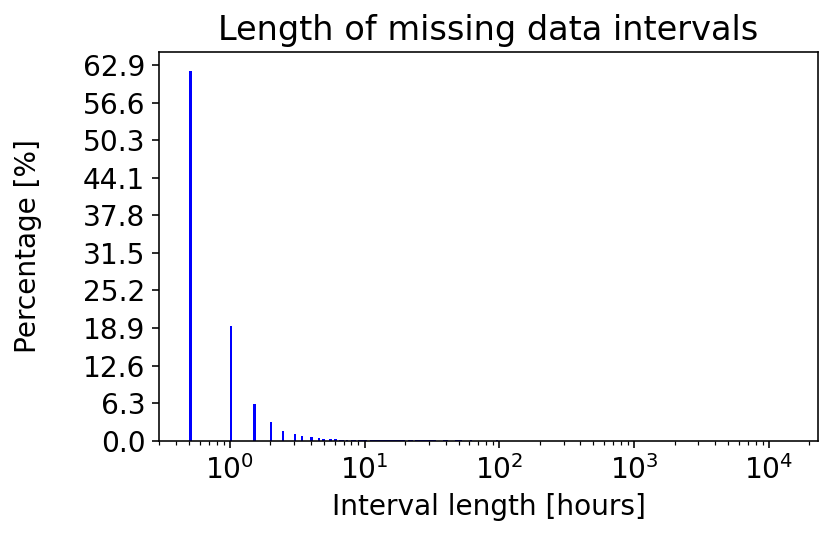

In [594]:
# (1) see what is the distribution of missing interval lengths?

missing_interval_lengths = get_nan_lengths(r_PM25.copy())
# plot
plot_nan_lengths_dist(missing_interval_lengths)

# account for the time! if I have 1 missing interval of 2000, 
# it equals 2000 intervals of 1. 


# am I keeping this distribution after extracting for validation?


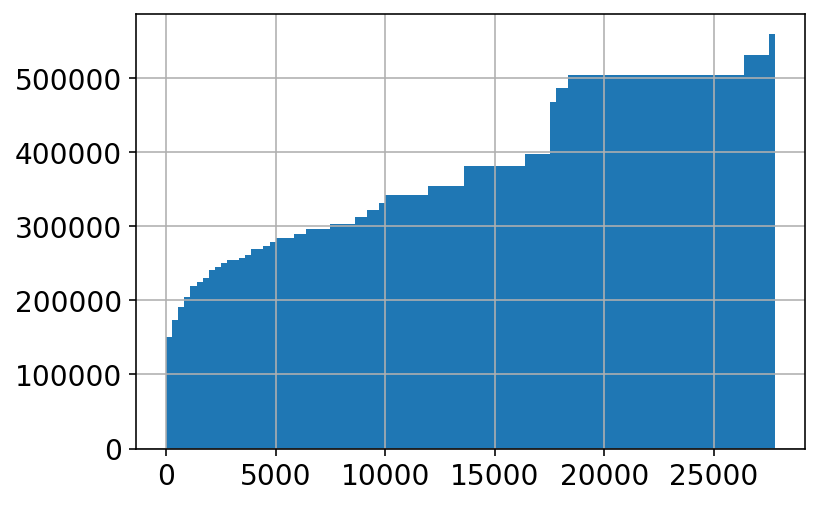

In [601]:
pd.Series(missing_interval_lengths).hist(weights=missing_interval_lengths, bins=100, cumulative=True)
# a,b = np.histogram(missing_interval_lengths,weights=missing_interval_lengths, bins=20)
# plt.plot(a.cumsum())

In [628]:
# non_missing_interval_lengths
d = [[x,x*missing_interval_lengths.count(x)*30/60] for x in set(missing_interval_lengths)]
e = np.array(sorted(d,key=lambda l:l[0]))
f = np.cumsum(e,axis=0)

# [[x,non_missing_interval_lengths.count(x)] for x in set(non_missing_interval_lengths)]
# distribution of hours missing from each interval type

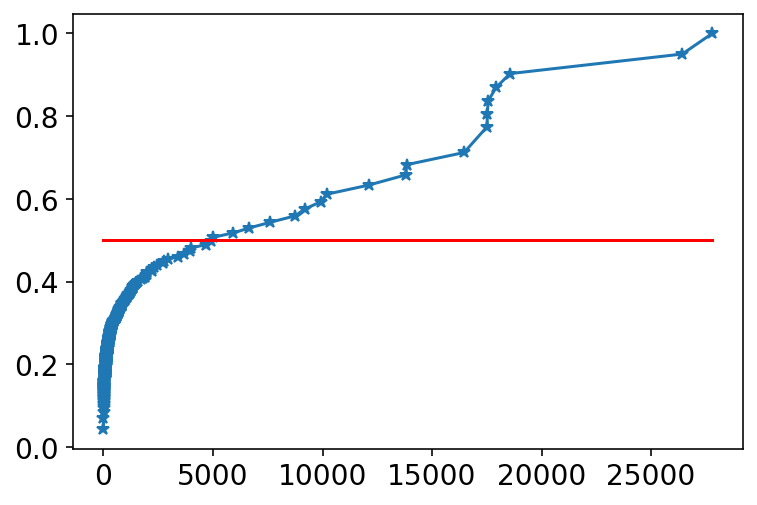

In [640]:
plt.plot(e[:,0],f[:,1]/f[-1,1],'-*');
plt.plot(e[:,0],0.5*np.ones(np.shape(f[:,1])),'r');

In [314]:
def get_nan_lengths(PM25):
       
    PM25[PM25.notnull()] = 1
    PM25[PM25.isnull()] = 0
    diffs = PM25.diff(axis = 0)

    missing_interval_lengths = []

    for monitor in range(PM25.shape[1]):

        #begining
        if PM25.iloc[0,monitor]==0:
            diffs.iloc[0,monitor]=-1

        #end
        if PM25.iloc[-1,monitor]==0:
            diffs.iloc[-1,monitor]=1

        row_start = np.where(diffs.iloc[:,monitor] == -1)[0]
        row_end = np.where(diffs.iloc[:,monitor] == 1)[0]

        xranges = list(list(zip(row_start,row_end-row_start)))
        missing_interval_lengths.extend(row_end-row_start)

    return missing_interval_lengths


def plot_nan_lengths_dist(missing_interval_lengths):
     
    data = [i*30/60 for i in missing_interval_lengths]#in hours
    _, bins = np.histogram(np.log10(data), bins='auto')

    # bins are unequal in width in a way that would make them look equal on a logarithmic scale.
    # matplotlib histogram
    plt.hist(data, color = 'blue',bins=10**bins)
    plt.gca().set_xscale("log")

    plt.title('Length of missing data intervals')
    plt.xlabel('Interval length [hours]')
    plt.ylabel('Percentage [%]\n')
    plt.yticks(ticks=np.arange(0,27500,2500),labels=np.round(100*np.arange(0,27500,2500)/len(data),1))
    
    # plt.ylim(0,1000)
    # plt.xlim(0,100)
    plt.tight_layout()
    plt.rcParams.update({'font.size': 14})

    plt.show();

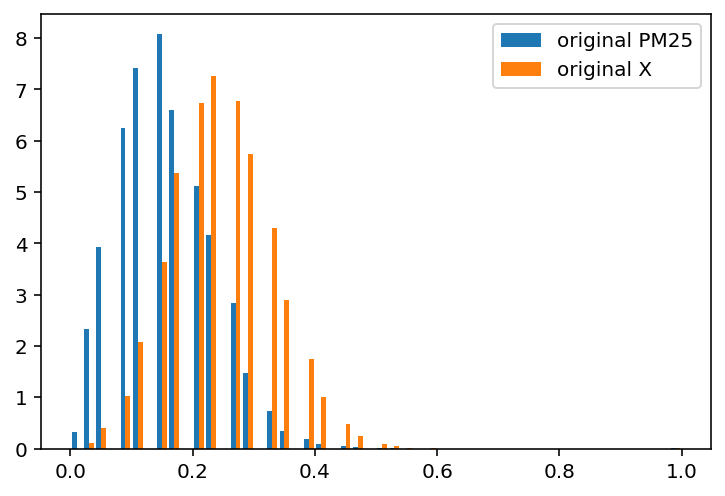

In [242]:
# (2) what is the distribution of each row (timestep) average missing values (out of 34 statiobs)?
# I cannot keep it of course... 
plt.hist([r_PM25.isnull().sum(axis = 1)/r_PM25.shape[1],np.isnan(np_X_missing).sum(axis = 1)/np_X_missing.shape[1]],bins=50,label=['original PM25','original X','imputed'],density=True);
plt.legend();
plt.show();

In [193]:
# what chunk sizes?
IL = [720,120,24,12,2,1,0.5]   
# IL = [1200, 100, 50, 10, 5, 1, 0.5]

In [592]:
np_X_missing, np_y_missing = return_X_y(r_PM25,IL)

# # for comparison - small chunks randomly spread
# np_X_missing, np_y_missing = return_randomly_spread_X_y(r_PM25,1440*34)

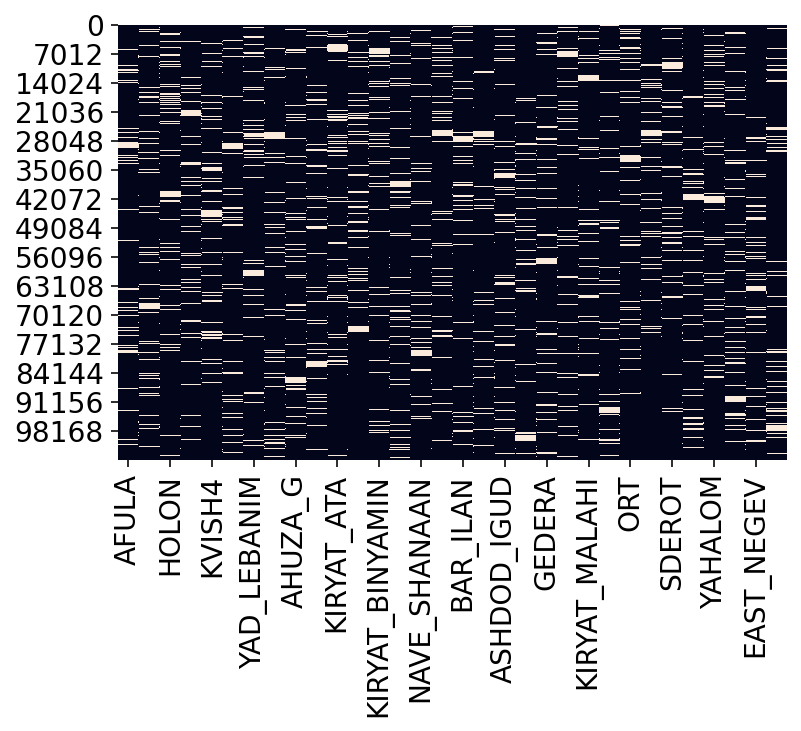

In [593]:
# plot the missing value chunks! see it is well distributed
y_missing = pd.DataFrame(np_y_missing,columns=r_PM25.columns)
sns.heatmap(y_missing.iloc[:,:32].notnull(), cbar=False);

In [652]:
# POSSIBLY - Remove rows where all is nan (5 like these)!!!

#### IterativeImputer Baysian Ridge

In [205]:
# PLEASE NORMALIZE BEFORE!

# impute
num_iter = 10
imputed = impute_ii_BR(np_X_missing, num_iter)
# validate
results = validate(imputed, np_y_missing)

# # save 
# imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
# imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/imputed_ii_BR_"+str(IL[0])+'_'+str(num_iter))
# results.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_ii_BR_"+str(IL[0])+'_'+str(num_iter))

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 6545.31410152833, scaled tolerance: 1.6975 
[IterativeImputer] Change: 830.801381839434, scaled tolerance: 1.6975 
[IterativeImputer] Change: 529.3613390270976, scaled tolerance: 1.6975 
[IterativeImputer] Change: 406.6275272475209, scaled tolerance: 1.6975 
[IterativeImputer] Change: 311.62118821853085, scaled tolerance: 1.6975 
[IterativeImputer] Change: 693.8534814712644, scaled tolerance: 1.6975 
[IterativeImputer] Change: 323.3173002724012, scaled tolerance: 1.6975 
[IterativeImputer] Change: 65.82711871794427, scaled tolerance: 1.6975 
[IterativeImputer] Change: 37.576752926504355, scaled tolerance: 1.6975 
[IterativeImputer] Change: 27.488189716912643, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)


In [206]:
results

,RMSE,MedianAE,MeanAE,R2
0,12.060933,4.721201,6.935338,0.735595


In [ ]:
# look at the distribution of the imputed values vs.

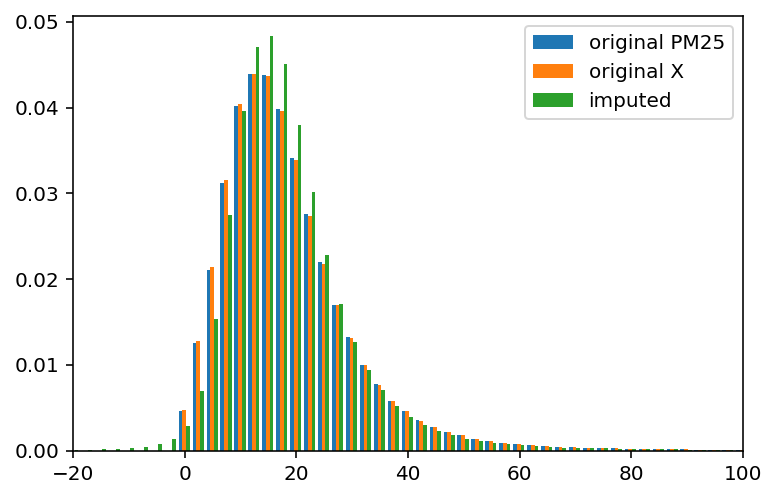

In [227]:
plot_hist(r_PM25.values, imputed,np_X_missing)

In [ ]:
# notes to myself

# Go back one week ago...: 
# FIRST choose model parameters by CV:
# try different k of KNN, different number of trees in a forest and boosting/no-boosting
# or how deep is the forest. AND - number of iterations!!!


# SECOND, evaluate the 4-5 best models (possibly add SVD):
# (1) randomly choose for each station a group of X types of interval lengths
# (those that together form like 95% of the data) - in total, let it be about 10% of
# average number of non-nan indexes. 
# (2) make sure that the dist. of missing station data in all time-steps (i.e., rows)
# is approximately saved (maybe a statistical test?)
# (3) impute
# (4) compare the imputed values with the not-imputed ones. Are they drawn from the same population (maybe a statisticel test?)
# (5) repeat for 50-25 times (a repeated holdout method)
# (6) Evaluate per interval length


#### IterativeImputer Random Forest

In [666]:
# impute
num_iter = 1
num_trees = 10
rnd_state_forRF = 0

imputed = impute_ii_RF(np_X_missing, num_iter, num_trees, rnd_state_forRF)
    
# validate
results = validate(imputed, np_y_missing)

# # save 
# imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
# imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/imputed_ii_RF_"+str(IL[0])+'_'+str(num_iter))
# results.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_ii_RF_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_trees))

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 3253.7229503349836, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)


In [658]:
results #6440*34

,RMSE,MedianAE,MeanAE,R2
0,9.112519,3.99,5.658814,0.843627


In [663]:
results #1440*34

,RMSE,MedianAE,MeanAE,R2
0,8.906374,3.88,5.525293,0.84776


In [667]:
results #1440*34 in chunk

,RMSE,MedianAE,MeanAE,R2
0,9.307076,3.73,5.364241,0.701416


#### IterativeImputer KNN

In [ ]:
weight_type = 'distance' #'uniform','distance'
num_iter = 10
num_neighbors = 10

imputed = impute_ii_KNN(np_X_missing, num_iter, num_neighbors, weight_type)

# validate
results = validate(imputed, np_y_missing)

# save 
imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/imputed_ii_KNN_"+str(IL[0])+'_'+str(num_iter))
results.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_ii_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors))

In [ ]:
results

#### My KNN

In [134]:
num_neighbors = 9
imputed = impute_my_KNN(np_X_missing, num_neighbors)

# validate
results = validate(imputed, np_y_missing)

# save 
imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/imputed_my_KNN_"+str(IL[0])+'_'+str(num_iter))
results.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_my_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors))

HBox(children=(IntProgress(value=0, max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, max=39), HTML(value='')))

HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

HBox(children=(IntProgress(value=0, max=89), HTML(value='')))

HBox(children=(IntProgress(value=0, max=53), HTML(value='')))

HBox(children=(IntProgress(value=0, max=136), HTML(value='')))

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

HBox(children=(IntProgress(value=0, max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

HBox(children=(IntProgress(value=0, max=114), HTML(value='')))

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

HBox(children=(IntProgress(value=0, max=19), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=59), HTML(value='')))

HBox(children=(IntProgress(value=0, max=86), HTML(value='')))

HBox(children=(IntProgress(value=0, max=54), HTML(value='')))

HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

HBox(children=(IntProgress(value=0, max=94), HTML(value='')))

HBox(children=(IntProgress(value=0, max=39), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, max=87), HTML(value='')))

HBox(children=(IntProgress(value=0, max=118), HTML(value='')))

HBox(children=(IntProgress(value=0, max=31), HTML(value='')))

HBox(children=(IntProgress(value=0, max=19), HTML(value='')))

HBox(children=(IntProgress(value=0, max=96), HTML(value='')))

HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

HBox(children=(IntProgress(value=0, max=101), HTML(value='')))

HBox(children=(IntProgress(value=0, max=87), HTML(value='')))

HBox(children=(IntProgress(value=0, max=98), HTML(value='')))

HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

In [135]:
results

,RMSE,MedianAE,MeanAE,R2
0,20.424791,3.880241,6.900915,0.653475


In [ ]:
# m (number of iterations) should be approximately as the average missing percentage. 
# which is about 15% in my case. ok to start with 5-10 though. 
# loose the 5 rows where all rows are empty!!!

In [4]:
# Ways to check randomness - https://www.theanalysisfactor.com/missing-data-mechanism/
# mark missing values in 1 and non-missing in zero. run a t-test or chi-square test 
# between one variable(column) and all other variables(columns). I think it should
# tell me if they are drown from the same poplutation (I want p-value not significant,
# meaning they are from different populations). if they come from the same population 
# I suspect that it is not random.
# MAYBE THE 0-1 IS TO TEST THE ORDER OF THE VALUES? IF IN RANDOM. = TEST FOR MCAR
# another option (I think test for MAR) is if I suspect that it is not completely random 
# (due to malfunctioning in a certain
# time maybe), I can try to train a logistic regression to see if time of day can 
# predict the missing non-missing classification. 

In [ ]:
# check the distribution of the imputed values Vs. the dist. of the non-missing values.

'''The idea is that good imputations have a distribution 
similar to the observed data. In other words, the imputations
could have been real values had they been observed. 
Except under MCAR, the distributions do not need to be identical, 
since strong MAR mechanisms may induce systematic differences between 
the two distributions. However, any dramatic differences between the 
imputed and observed data should certainly alert us to the possibility
that something is wrong.'''

In [ ]:
# https://stefvanbuuren.name/fimd/sec-nutshell.html
# http://www.stat.columbia.edu/~gelman/arm/missing.pdf

# TRY ALSO THE MICE FROM FANCYIMPUTE - IS IT THE SAME AS ITERTIVEIMPUTER?
# https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation


# MAYBE ADD missSVD?